In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data=pd.read_csv("/content/TwitterAirlines.csv")

In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0.0,@VirginAmerica What @dhepburn said.,NaN,24-02-2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0.0,@VirginAmerica I didn't today... Must mean I n...,NaN,24-02-2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      5499 non-null   float64
 1   airline_sentiment             5499 non-null   object 
 2   airline_sentiment_confidence  5499 non-null   float64
 3   negativereason                3445 non-null   object 
 4   negativereason_confidence     4000 non-null   float64
 5   airline                       5499 non-null   object 
 6   airline_sentiment_gold        11 non-null     object 
 7   name                          5499 non-null   object 
 8   negativereason_gold           9 non-null      object 
 9   retweet_count                 5499 non-null   float64
 10  text                          5499 non-null   object 
 11  tweet_coord                   445 non-null    object 
 12  tweet_created                 5499 non-null   object 
 13  t

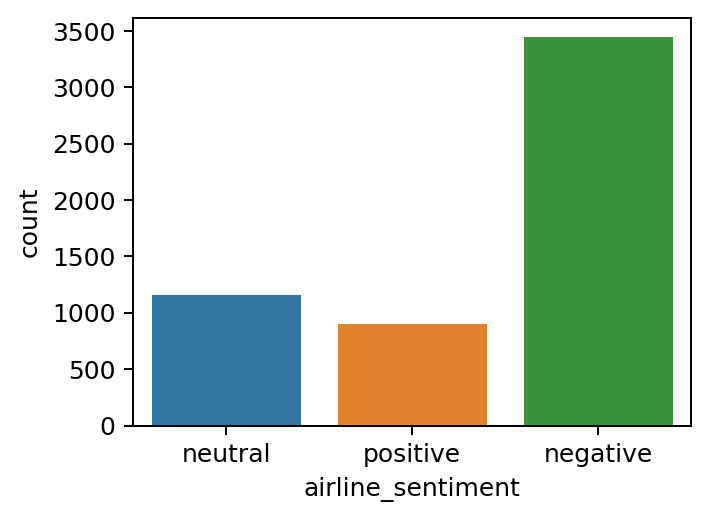

In [ ]:
plt.figure(figsize=(4,3),dpi=180)
sns.countplot(x=data['airline_sentiment'])

In [ ]:
data['airline_sentiment'].value_counts()

negative    3445
neutral     1157
positive     897
Name: airline_sentiment, dtype: int64

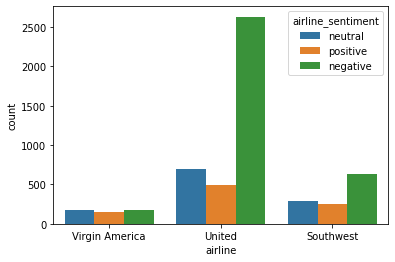

In [ ]:
#Sentiment for each airline
sns.countplot(x=data['airline'],hue=data['airline_sentiment'])
#United has the most negative sentiments, while Virgin America has the lowest

In [ ]:
# percentage of the negative reviews for each airline.
neg_review = data[data['airline_sentiment']=='negative']
neg_review.shape

(3445, 15)

In [ ]:
neg_review['airline_sentiment'].unique()

array(['negative'], dtype=object)

In [ ]:
total_neg = pd.DataFrame(neg_review.groupby('airline')['airline_sentiment'].count())

In [ ]:
total_neg = total_neg.reset_index()
total_neg

,airline,airline_sentiment
0,Southwest,631
1,United,2633
2,Virgin America,181


In [ ]:
all_review = pd.DataFrame(data.groupby('airline')['airline_sentiment'].count()).reset_index()
all_review

,airline,airline_sentiment
0,Southwest,1173
1,United,3822
2,Virgin America,504


In [ ]:
all_review.columns = ['airline','total_reviews']
all_review

,airline,total_reviews
0,Southwest,1173
1,United,3822
2,Virgin America,504


In [ ]:
all_review['neg_reviews'] = total_neg['airline_sentiment']
all_review['neg_percent_reviews'] = all_review['neg_reviews'] / all_review['total_reviews']
all_review

,airline,total_reviews,neg_reviews,neg_percent_reviews
0,Southwest,1173,631,0.537937
1,United,3822,2633,0.688906
2,Virgin America,504,181,0.359127


#**Data Cleaning**

From the dataset, we only need two columns (text and airline_sentiment)

In [ ]:
df = data[['text','airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
df.shape

(14640, 2)

In [ ]:
df=df.dropna()
df = df.reset_index(drop=True)
df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
5494,@SouthwestAir well my mom called earlier and y...,negative
5495,@SouthwestAir there's an hour wait here for re...,negative
5496,@SouthwestAir it says I can't because my fligh...,negative
5497,@SouthwestAir can you help me with reFlight Bo...,negative


In [ ]:
#Checking missing values
df.isna().sum()

text                 0
airline_sentiment    0
dtype: int64

In [ ]:
#Check the duplicates
df.duplicated().sum()

20

In [ ]:
#Remove the duplicates
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.shape

(5479, 2)

### **Preprocessing**

In [ ]:
### Lower casing
df['pre_process'] = df['text'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))

<ipython-input-23-d997a2fdecfc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_process'] = df['text'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))


In [ ]:
df.head()

,text,airline_sentiment,pre_process
0,@VirginAmerica What @dhepburn said.,neutral,@virginamerica what @dhepburn said.
1,@VirginAmerica plus you've added commercials t...,positive,@virginamerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,@virginamerica i didn't today... must mean i n...
3,@VirginAmerica it's really aggressive to blast...,negative,@virginamerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...,negative,@virginamerica and it's a really big bad thing...


In [ ]:
####Remove the HTML tags and URLs from the reviews.

In [ ]:
from bs4 import BeautifulSoup
df['pre_process']=df['pre_process'].apply(lambda x: BeautifulSoup(x).get_text())
import re
df['pre_process']=df['pre_process'].apply(lambda x: re.sub(r'http\S+', '', x)) 

<ipython-input-26-9810ffa99a7a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_process']=df['pre_process'].apply(lambda x: BeautifulSoup(x).get_text())
<ipython-input-26-9810ffa99a7a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_process']=df['pre_process'].apply(lambda x: re.sub(r'http\S+', '', x))


In [ ]:
df.head()

,text,airline_sentiment,pre_process
0,@VirginAmerica What @dhepburn said.,neutral,@virginamerica what @dhepburn said.
1,@VirginAmerica plus you've added commercials t...,positive,@virginamerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,@virginamerica i didn't today... must mean i n...
3,@VirginAmerica it's really aggressive to blast...,negative,@virginamerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...,negative,@virginamerica and it's a really big bad thing...


In [ ]:
def contractions(s): #need to manually put in all the words we want to replace
    s = re.sub(r"won't", "will not",s)
    s = re.sub(r"would't", "would not",s)
    s = re.sub(r"could't", "could not",s)
    s = re.sub(r"\'d", " would",s)
    s = re.sub(r"can\'t", "can not",s)
    s = re.sub(r"n\'t", " not", s)
    s= re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    return s
df['pre_process']=df['pre_process'].apply(lambda x:contractions(x))

<ipython-input-28-bb4131529a66>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_process']=df['pre_process'].apply(lambda x:contractions(x))


In [ ]:
df.head()

,text,airline_sentiment,pre_process
0,@VirginAmerica What @dhepburn said.,neutral,@virginamerica what @dhepburn said.
1,@VirginAmerica plus you've added commercials t...,positive,@virginamerica plus you have added commercials...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,@virginamerica i did not today... must mean i ...
3,@VirginAmerica it's really aggressive to blast...,negative,@virginamerica it is really aggressive to blas...
4,@VirginAmerica and it's a really big bad thing...,negative,@virginamerica and it is a really big bad thin...


In [ ]:
#Remove non-alpha characters
nltk.download('punkt')
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)])) # ^ indicates not, so the special chracters will be removed

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-30-db5f01429ad1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_process']=df['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)])) # ^ indicates not, so the special chracters will be removed


In [ ]:
df.head(10)

,text,airline_sentiment,pre_process
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica what dhepburn said
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus you have added commercials...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,virginamerica i did not today must mean i ne...
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica it is really aggressive to blas...
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica and it is a really big bad thin...
5,@VirginAmerica seriously would pay $30 a fligh...,negative,virginamerica seriously would pay a flight ...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,virginamerica yes nearly every time i fly vx...
7,@VirginAmerica Really missed a prime opportuni...,neutral,virginamerica really missed a prime opportuni...
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,virginamerica well i did notbut now i do d
9,"@VirginAmerica it was amazing, and arrived an ...",positive,virginamerica it was amazing and arrived an ...


In [ ]:
##Remove the extra spaces between the words
df['pre_process']=df['pre_process'].apply(lambda x: re.sub(' +', ' ', x)) #Multiple spaces will be replaced by single space

<ipython-input-32-9161d2f1cb96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_process']=df['pre_process'].apply(lambda x: re.sub(' +', ' ', x)) #Multiple spaces will be replaced by single space


In [ ]:
#### Remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-33-e733f495534a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_process']=df['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))


In [ ]:
df.head()

,text,airline_sentiment,pre_process
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus added commercials experienc...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,virginamerica today must mean need take anothe...
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica really big bad thing


In [ ]:
#### Lemmatization
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-35-bec09307288d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_process']=df['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))


In [ ]:
df.head()

,text,airline_sentiment,pre_process
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus added commercial experience...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,virginamerica today must mean need take anothe...
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica really big bad thing


In [ ]:
###Split the Data into Training and Testing sets
from sklearn.model_selection import train_test_split #processed data 
X_train,X_test,Y_train, Y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.25, random_state=30)
print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

Train:  (4109,) (4109,) Test:  ((1370,), (1370,))


In [ ]:
####Feature extraction
##### TF-IDF vectorizer

In [ ]:
print("TFIDF Vectorizer……")
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train) #word embedding for training data
tf_x_test = vectorizer.transform(X_test)

TFIDF Vectorizer……


In [ ]:
tf_x_train.shape

(4109, 7264)

In [ ]:
tf_x_test.shape

(1370, 7264)

In [ ]:
len(vectorizer.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


7264

#**SVM algorithm**


In [ ]:
from sklearn.svm import LinearSVC #SVC-support vector classifier
clf = LinearSVC(random_state=0) #Linear Kernal

In [ ]:
###Fitting the Training data into model
clf.fit(tf_x_train,Y_train)

LinearSVC(random_state=0)

In [ ]:
###Predicting the Test data
y_test_pred=clf.predict(tf_x_test)
y_test_pred

array(['positive', 'negative', 'negative', ..., 'negative', 'positive',
       'neutral'], dtype=object)

In [ ]:
#Analyzing the results
from sklearn.metrics import classification_report
report=classification_report(Y_test, y_test_pred,output_dict=True)

In [ ]:
report

{'negative': {'precision': 0.8228630278063852,
  'recall': 0.9269141531322506,
  'f1-score': 0.8717948717948718,
  'support': 862},
 'neutral': {'precision': 0.6299559471365639,
  'recall': 0.5070921985815603,
  'f1-score': 0.5618860510805501,
  'support': 282},
 'positive': {'precision': 0.7906976744186046,
  'recall': 0.6017699115044248,
  'f1-score': 0.6834170854271356,
  'support': 226},
 'accuracy': 0.7868613138686131,
 'macro avg': {'precision': 0.7478388831205179,
  'recall': 0.6785920877394119,
  'f1-score': 0.7056993361008526,
  'support': 1370},
 'weighted avg': {'precision': 0.7778490375768027,
  'recall': 0.7868613138686131,
  'f1-score': 0.776927961458706,
  'support': 1370}}

#**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(max_iter=1000,solver='saga')

In [ ]:
clf1.fit(tf_x_train,Y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [ ]:
y_test_pred1=clf1.predict(tf_x_test)

In [ ]:
from sklearn.metrics import classification_report
report1=classification_report(Y_test, y_test_pred1,output_dict=True)

In [ ]:
report1

{'negative': {'precision': 0.7763280521901211,
  'recall': 0.9663573085846868,
  'f1-score': 0.8609819121447029,
  'support': 862},
 'neutral': {'precision': 0.6815642458100558,
  'recall': 0.4326241134751773,
  'f1-score': 0.5292841648590022,
  'support': 282},
 'positive': {'precision': 0.8898305084745762,
  'recall': 0.4646017699115044,
  'f1-score': 0.6104651162790697,
  'support': 226},
 'accuracy': 0.7737226277372263,
 'macro avg': {'precision': 0.7825742688249178,
  'recall': 0.6211943973237896,
  'f1-score': 0.6669103977609249,
  'support': 1370},
 'weighted avg': {'precision': 0.775545688482901,
  'recall': 0.7737226277372263,
  'f1-score': 0.7513793131664542,
  'support': 1370}}

#**Final Model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score,f1_score, ConfusionMatrixDisplay,classification_report

In [ ]:
df_results = pd.DataFrame()
df_results['Algorithm'] = [ 'SVM', 'LogisticRegression']
df_results['Accuracy Score'] = [accuracy_score(y_test_pred,Y_test),accuracy_score(y_test_pred1,Y_test) ]
df_results.columns = ['Algorithm','Score']
df_results

,Algorithm,Score
0,SVM,0.786861
1,LogisticRegression,0.773723


In [ ]:
#The above results show that here SVM performed better than Logistic Regression.